In [1]:
%matplotlib inline
import numpy as np
from rnn.arch import RNN
from vae.arch import VAE
import matplotlib.pyplot as plt
from gym.utils import seeding

batch_num = 0

/Users/davidfoster/.virtualenvs/worldmodels/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
rnn = RNN()
rnn.set_weights('./rnn/weights.h5')

vae = VAE()
vae.set_weights('./vae/weights.h5')

In [3]:
# obs_data = np.load('./data/obs_data_car_racing_' + str(batch_num) + '.npy') 
# action_data = np.load('./data/action_data_car_racing_' + str(batch_num) + '.npy')
# reward_data = np.load('./data/reward_data_car_racing_' + str(batch_num) + '.npy') 
# done_data = np.load('./data/done_data_car_racing_' + str(batch_num) + '.npy')
rnn_input = np.load('./data/rnn_input_' + str(batch_num) + '.npy') 
rnn_output = np.load('./data/rnn_output_' + str(batch_num) + '.npy')

In [4]:
rnn_input[0].shape

(299, 35)

In [5]:
rnn_output[0].shape

(299, 34)

In [6]:
GAUSSIAN_MIXTURES = 5
Z_DIM = 32
z_dim = 32

def get_mixture_coef(z_pred):

    log_pi, mu, log_sigma = np.split(z_pred, 3, 1)
    log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))

    return log_pi, mu, log_sigma


In [7]:
def get_pi_idx(x, pdf):
  # samples from a categorial distribution
  N = pdf.size
  accumulate = 0
  for i in range(0, N):
    accumulate += pdf[i]
    if (accumulate >= x):
      return i
  random_value = np.random.randint(N)
  #print('error with sampling ensemble, returning random', random_value)
  return random_value

In [204]:
def sample_z(mu, log_sigma):
    z = mu + (np.exp(log_sigma)) * np_random.randn(*log_sigma.shape) * 0.1
    return z

In [9]:
np_random, seed = seeding.np_random()

In [49]:
def sample_next_mdn_output(obs):
    
    d = GAUSSIAN_MIXTURES * Z_DIM
    
    y_pred = rnn.model.predict(np.array([[obs]]))
    z_pred = y_pred[:,:,:3*d]
    z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])

    log_pi, mu, log_sigma = get_mixture_coef(z_pred)

    chosen_log_pi = np.zeros(z_dim)
    chosen_mu = np.zeros(z_dim)
    chosen_log_sigma = np.zeros(z_dim)

    for j in range(z_dim):
      idx = get_pi_idx(np_random.rand(), log_pi[j,:])
      chosen_log_pi[j] = idx
      chosen_mu[j] = mu[j,idx]
      chosen_log_sigma[j] = log_sigma[j,idx]
        
    

    next_z = sample_z(chosen_mu, chosen_log_sigma)

#     reward = np.exp(reward) / (1 + np.exp(reward))
#     done = np.exp(done) / (1 + np.exp(done))

#     if reward > 0.5:
#         next_reward = 3.2
#     else:
#         next_reward = -0.1

#     if done > 0.5:
#         next_done = True
#     else:
#         next_done = False
        
#     return next_z, next_reward, next_done, chosen_mu, chosen_sigma, chosen_pi

    return next_z, chosen_mu, chosen_log_sigma, chosen_log_pi

In [217]:
idx = 0
obs = rnn_input[0]
actual = rnn_output[0] 
obs.shape

(299, 35)

<function matplotlib.pyplot.show>

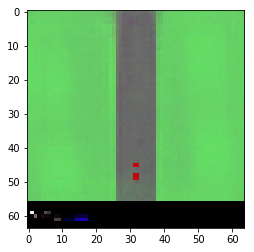

In [218]:
z_decoded = vae.decoder.predict(np.array(obs[:, :32]))
plt.imshow(z_decoded[idx])
plt.show

<function matplotlib.pyplot.show>

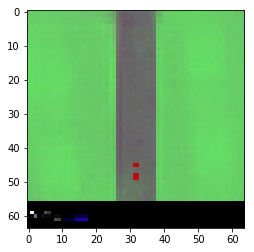

In [219]:
actual_z_decoded = vae.decoder.predict(np.array(actual[:, :32]))
plt.imshow(actual_z_decoded[idx])
plt.show

In [246]:
next_z = obs[idx,:]

(32,)


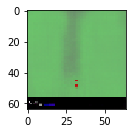

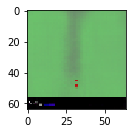

In [285]:
# next_z, next_reward, next_done, chosen_mu, chosen_sigma, chosen_pi = sample_next_mdn_output(obs)
next_z, chosen_mu, chosen_log_sigma, chosen_pi = sample_next_mdn_output(next_z)
# print(chosen_pi)
# print(chosen_mu)
# print(chosen_log_sigma)

# print(next_z)



next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
next_mu_decoded = vae.decoder.predict(np.array([chosen_mu]))[0]

next_z = np.concatenate([next_z, [1,1,0]])



plt.subplot(211)
plt.imshow( next_z_decoded)
plt.show()
plt.subplot(221)
plt.imshow( next_mu_decoded)
plt.show()
# plt.imshow(next_z_decoded)
# plt.show()

(34, 299)


/Users/davidfoster/.virtualenvs/worldmodels/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


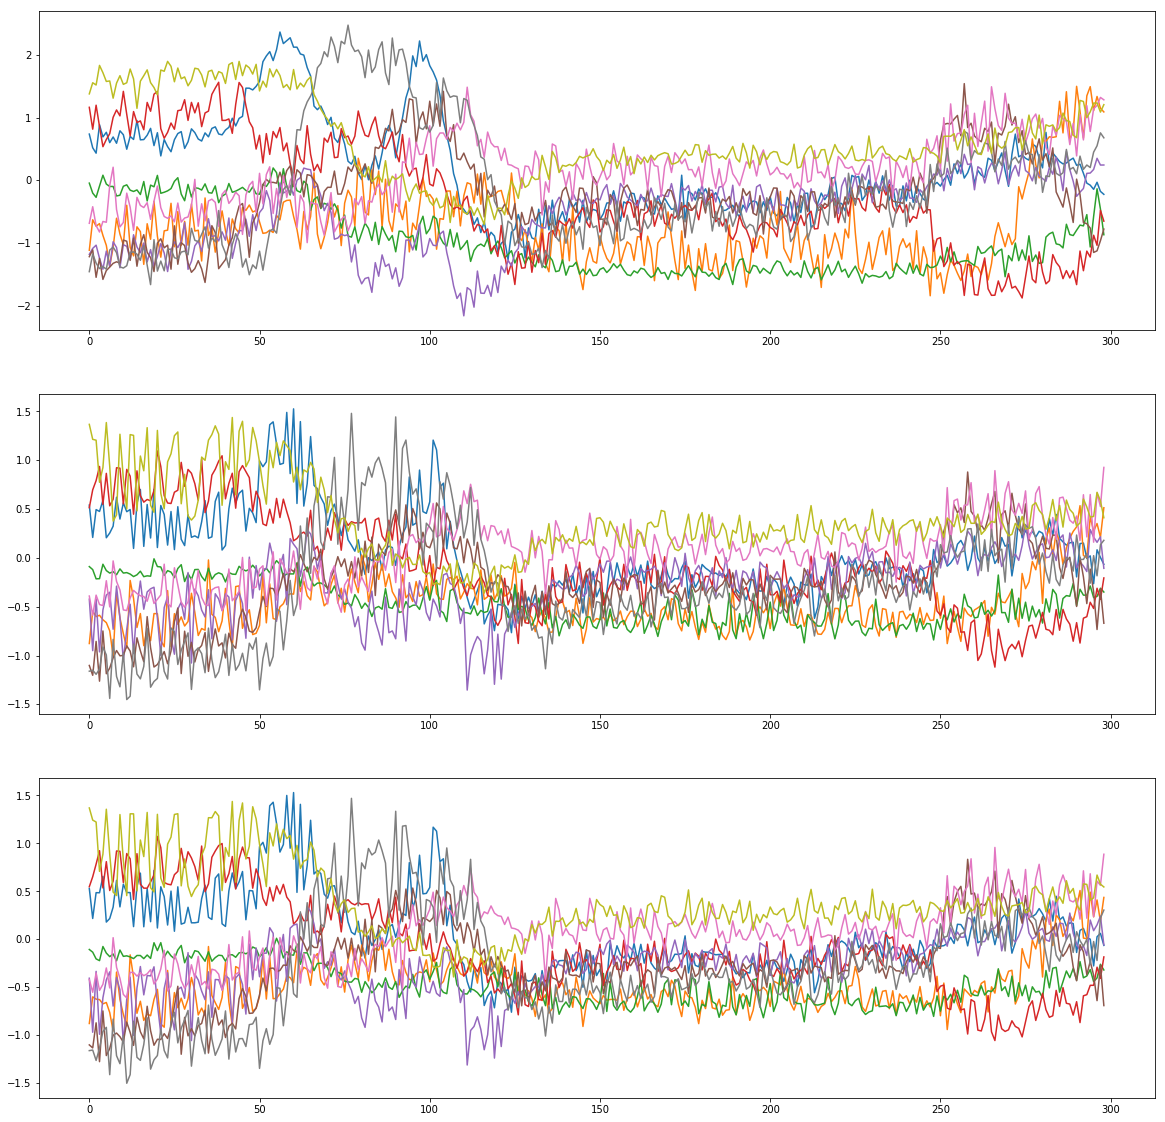

In [206]:
b = np.swapaxes(rnn_output[0],0,1)
print(b.shape)

next_zs = np.zeros(shape = (32,299))
next_mus = np.zeros(shape = (32,299))
# next_z = np.copy(obs)
# print(next_z.shape)
for i in range(299):
    next_z, chosen_mu, chosen_log_sigma, chosen_pi = sample_next_mdn_output(obs[i,:])
    next_mus[:,i] = chosen_mu
    next_zs[:,i] = next_z
    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
    
    # plt.imshow(next_z_decoded)
    # plt.show()
    # next_z = np.concatenate([next_z, np.array([0,1,0])])

plt.figure(figsize=(20,20))
for i in [5,10,13,15,16,22, 24, 30, 31]:
    plt.subplot(311)
    plt.plot( b[i,:])
    plt.subplot(312)
    plt.plot( next_zs[i,:])
    plt.subplot(313)
    plt.plot( next_mus[i,:])
    
# print(next_zs)
    

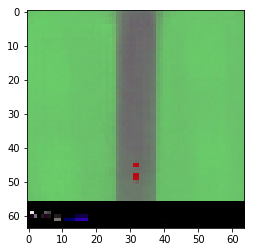

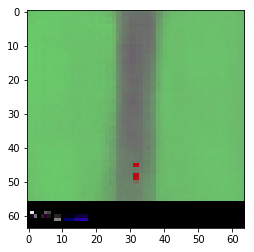

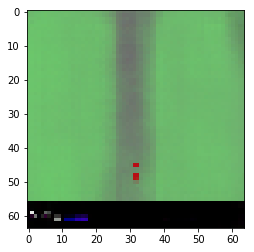

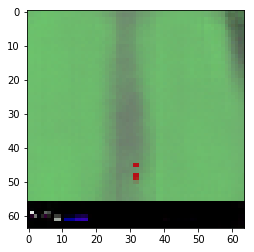

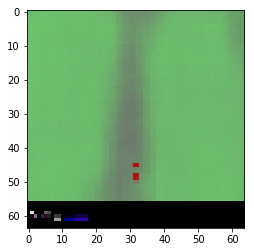

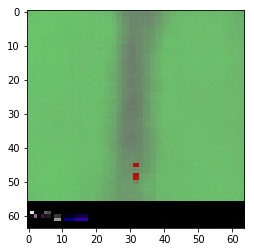

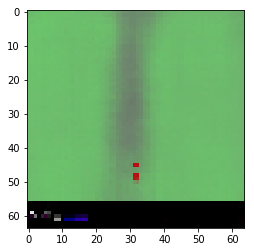

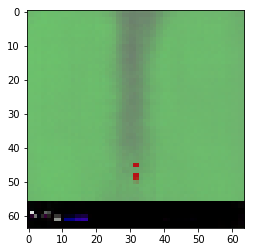

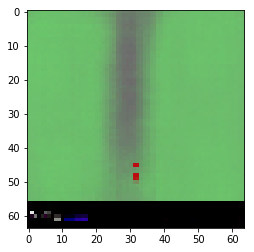

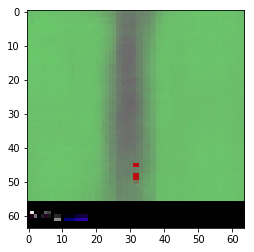

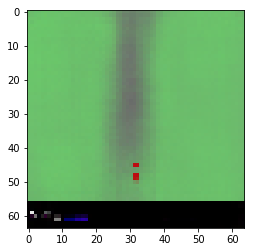

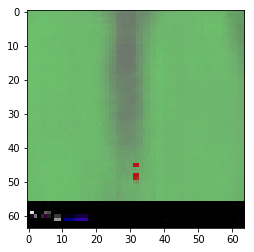

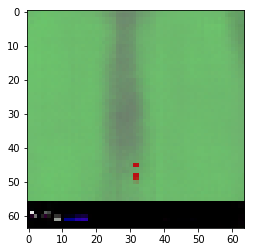

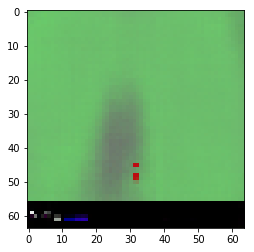

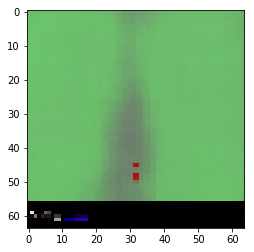

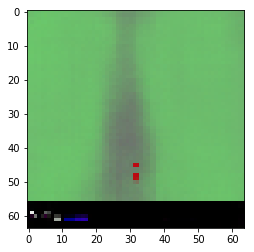

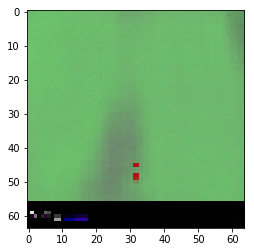

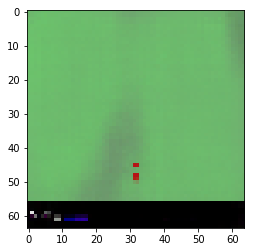

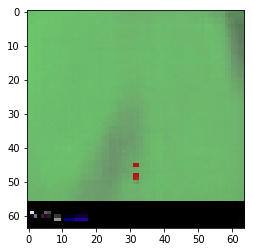

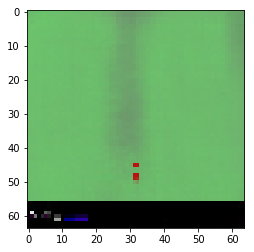

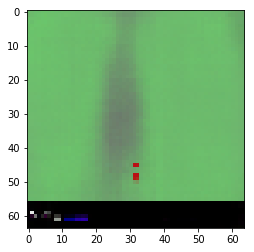

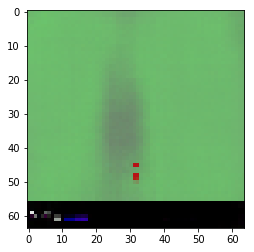

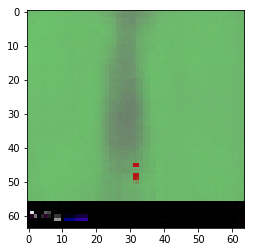

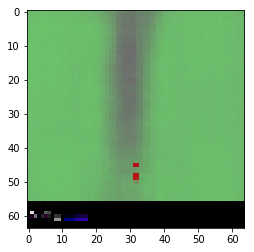

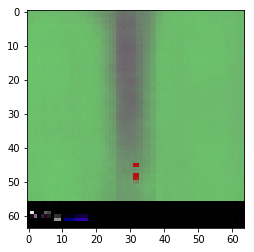

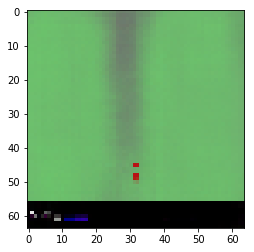

KeyboardInterrupt: 

In [223]:

next_z = obs[0]
# next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
# plt.imshow( next_z_decoded)
# plt.show()

for i in range(300):
#     print(np.array([[next_z]]).shape)
    next_z, chosen_mu, chosen_log_sigma, chosen_pi = sample_next_mdn_output(next_z)

    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
#     next_mu_decoded = vae.decoder.predict(np.array([chosen_mu]))[0]

    next_z = np.concatenate([next_z, [1,1,0]])

#     plt.subplot(211)
    plt.imshow( next_z_decoded)
    plt.show()
#     plt.subplot(221)
#     plt.imshow( next_mu_decoded)
#     plt.show()
    # plt.imshow(next_z_decoded)
    # plt.show()